In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.svm import SVC

In [2]:
# 데이터 로드
data = pd.read_csv('datasets/코스피이상치99%처리.csv')

# 타겟 변수 및 피처 선택
X = data[['당기순이익률(%)', 
          '총자본증가율(전년동기)(%)', 
          '무형자산구성비율(%)', '타인자본비율(%)', '당좌비율(%)', 
          '매출채권회전율(회)', 
          '영업현금흐름/투자현금흐름(%)', 
          'SGAI']]
y = data['분식기업']

# 수치형 피처만 선택
X_numeric = X.select_dtypes(include=[np.number])

# 트레인/테스트 셋 분리 (벤포드 항목 포함)
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
standard = StandardScaler()
X_train_scaled = standard.fit_transform(X_train)

ratios = {
    'under': [0.1, 0.3, 0.5, 0.7]}
results = {}

# 각 리샘플링 비율에 대해 모델 훈련 및 성능 평가
for method, ratios_list in ratios.items():
    for ratio in ratios_list:
        resampled_data = {}
        if method == 'under':
            sampler = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
        else:
            sampler = SMOTE(sampling_strategy=ratio, random_state=42)

        final_X_train, final_y_train = sampler.fit_resample(X_train_scaled, y_train)


In [10]:
rus = RUSBoostClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'random_state': [42]}
grid_search = GridSearchCV(rus, param_grid, cv=kfold, scoring='recall', n_jobs=-1)
grid_search.fit(final_X_train, final_y_train)

sample_weight = compute_sample_weight(class_weight='balanced', y=final_y_train)
grid_search.fit(final_X_train, final_y_train, sample_weight=sample_weight)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RUSBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [50, 100, 150], 'random_state': [42]},
             scoring='recall')

In [9]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)


RUSBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=42)
{'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 42}
0.8493340961098397


In [12]:
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1_score = f1_score(y_test, y_pred)
test_confusion_matrix = confusion_matrix(y_test, y_pred)

print(f'  테스트 세트 정확도: {test_accuracy:.4f}')
print(f'  테스트 세트 정밀도: {test_precision:.4f}')
print(f'  테스트 세트 재현율: {test_recall:.4f}')
print(f'  테스트 세트 F1 스코어: {test_f1_score:.4f}')
print(f'  테스트 세트 혼동 행렬:')
print(test_confusion_matrix)
print('--------------------------------------------------')

  테스트 세트 정확도: 0.5415
  테스트 세트 정밀도: 0.0261
  테스트 세트 재현율: 0.6071
  테스트 세트 F1 스코어: 0.0500
  테스트 세트 혼동 행렬:
[[746 635]
 [ 11  17]]
--------------------------------------------------


c:\Users\Master\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RUSBoostClassifier was fitted without feature names
  warnings.warn(


In [13]:
# 최적의 모델
best_model = grid_search.best_estimator_

# 회귀 계수 추출
coefficients = best_model.coef_

# 각 피처와 해당 회귀 계수를 연결하는 데이터프레임 생성
coefficients_df = pd.DataFrame(coefficients, columns=X_train.columns)
coefficients_df

AttributeError: 'RUSBoostClassifier' object has no attribute 'coef_'

In [41]:
best_model.intercept_

array([-0.07386418])

In [16]:
y_prob = grid_search.predict_proba(X_test)[:, 1]

# 다양한 임계값에 대해 성능을 평가합니다.
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    # 임계값을 기준으로 이진 분류를 수행합니다.
    y_pred = [1 if prob >= threshold else 0 for prob in y_prob]
    
    # 정확도를 계산하여 출력합니다.
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    rus_f1_score = f1_score(y_test, y_pred)
    rus_confusion_matrix = confusion_matrix(y_test, y_pred)
    print("Threshold:", threshold, "Accuracy:", accuracy)
    print("Threshold:", threshold, "precision:", precision)
    print("Threshold:", threshold, "recall:", recall)
    print("Threshold:", threshold, "f1_score:", rus_f1_score)
    print("Threshold:", threshold, "confusion_matrix:", rus_confusion_matrix)

c:\Users\Master\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RUSBoostClassifier was fitted without feature names
  warnings.warn(


Threshold: 0.1 Accuracy: 0.0198722498225692
Threshold: 0.1 precision: 0.0198722498225692
Threshold: 0.1 recall: 1.0
Threshold: 0.1 f1_score: 0.03897007654836465
Threshold: 0.1 confusion_matrix: [[   0 1381]
 [   0   28]]
Threshold: 0.2 Accuracy: 0.0198722498225692
Threshold: 0.2 precision: 0.0198722498225692
Threshold: 0.2 recall: 1.0
Threshold: 0.2 f1_score: 0.03897007654836465
Threshold: 0.2 confusion_matrix: [[   0 1381]
 [   0   28]]
Threshold: 0.3 Accuracy: 0.0198722498225692
Threshold: 0.3 precision: 0.0198722498225692
Threshold: 0.3 recall: 1.0
Threshold: 0.3 f1_score: 0.03897007654836465
Threshold: 0.3 confusion_matrix: [[   0 1381]
 [   0   28]]
Threshold: 0.4 Accuracy: 0.0205819730305181
Threshold: 0.4 precision: 0.019886363636363636
Threshold: 0.4 recall: 1.0
Threshold: 0.4 f1_score: 0.03899721448467967
Threshold: 0.4 confusion_matrix: [[   1 1380]
 [   0   28]]
Threshold: 0.5 Accuracy: 0.5415188076650106
Threshold: 0.5 precision: 0.02607361963190184
Threshold: 0.5 recall: 0

c:\Users\Master\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
roc_auc

0.6011689252094755

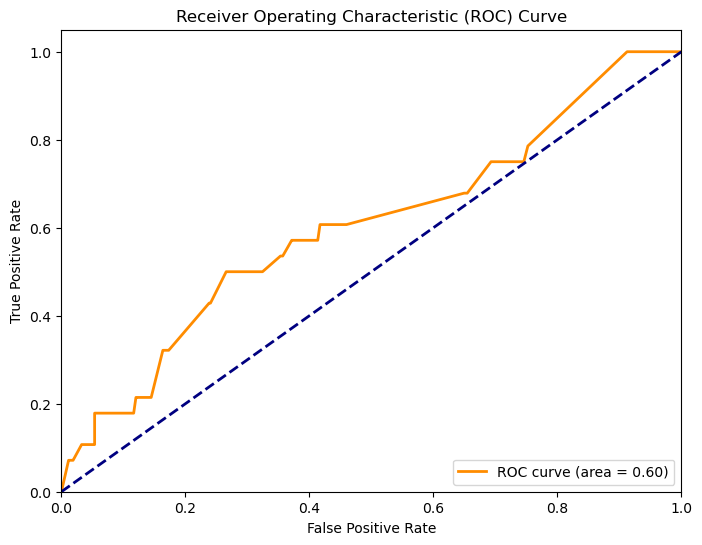

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC 곡선을 그리기 위해 fpr, tpr을 계산합니다.
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()